# Deep Learning Practical 4  
## Imbalanced Image Classification and Model Comparison



In [1]:
# 0) GPU check (no nvidia-smi dependency)

import torch
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

CUDA available: True
GPU: Tesla T4


In [4]:
# 1) Install deps

!pip install -q torch torchvision torchaudio scikit-learn matplotlib thop tqdm umap-learn grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 35.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [5]:

# 2) Imports

import os, time, math, random, copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass
from tqdm import tqdm

from torch.utils.data import DataLoader, Subset, WeightedRandomSampler
from torchvision import datasets, transforms, models
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score,
    precision_score, recall_score, confusion_matrix,
    roc_auc_score, average_precision_score
)
import matplotlib.pyplot as plt
from thop import profile
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [6]:

# 3) Reproducibility

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # Make deterministic (slower but repeatable)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)


In [7]:

# 4) Config

@dataclass
class CFG:
    # Choose two datasets:
    # dataset_a: "cifar10_imbalanced" OR "flowers" (ImageFolder path)
    # dataset_b: another one
    dataset_a: str = "cifar10_imbalanced"
    dataset_b: str = "flowers"  # change if you only use CIFAR10 + another ImageFolder
    flowers_path: str = "/content/flowers"  # ImageFolder root: /content/flowers/train, /content/flowers/val (or split below)

    # CIFAR imbalance settings
    cifar_imbalance_ratio: int = 100  # long-tailed ratio 100:1

    # Model comparison (at least 2)
    models_to_compare: tuple = ("resnet18", "efficientnet_b0")  # add "mobilenet_v2", "vgg16", "custom_cnn"
    pretrained: bool = True  # transfer learning option (ImageNet weights)

    # Loss / optimizer experiments
    loss_name: str = "focal"  # "ce", "weighted_ce", "focal", "class_balanced", "label_smoothing"
    focal_gamma: float = 2.0
    label_smoothing: float = 0.1

    optimizer_name: str = "adamw"  # "sgd", "adam", "adamw", "rmsprop"
    lr: float = 3e-4
    weight_decay: float = 1e-4
    momentum: float = 0.9

    # Imbalance handling
    use_weighted_sampler: bool = True
    use_class_weights_in_loss: bool = True

    # Training
    epochs: int = 5
    batch_size: int = 128
    num_workers: int = 2
    image_size: int = 224  # use 224 for pretrained ImageNet backbones

    # Feature viz
    viz_samples: int = 1500

cfg = CFG()




In [8]:

# 5) Utilities

def one_hot(y, num_classes):
    y = np.asarray(y)
    oh = np.zeros((len(y), num_classes), dtype=np.float32)
    oh[np.arange(len(y)), y] = 1.0
    return oh

def gmean_from_cm(cm):
    # G-Mean = geometric mean of per-class recall
    recalls = []
    for i in range(cm.shape[0]):
        tp = cm[i, i]
        fn = cm[i, :].sum() - tp
        rec = tp / (tp + fn + 1e-12)
        recalls.append(rec)
    recalls = np.array(recalls)
    return float(np.exp(np.mean(np.log(recalls + 1e-12))))

def topk_accuracy(logits, y_true, k=5):
    # logits: [N,C], y_true: [N]
    topk = np.argsort(-logits, axis=1)[:, :k]
    hit = (topk == y_true[:, None]).any(axis=1)
    return float(hit.mean())

def count_params(model):
    return sum(p.numel() for p in model.parameters())

@torch.no_grad()
def inference_time_ms(model, loader, iters=30):
    model.eval()
    # warmup
    x, _ = next(iter(loader))
    x = x.to(device)
    for _ in range(10):
        _ = model(x)
    torch.cuda.synchronize() if device.type == "cuda" else None

    times = []
    for _ in range(iters):
        start = time.time()
        _ = model(x)
        torch.cuda.synchronize() if device.type == "cuda" else None
        times.append((time.time() - start) * 1000)
    return float(np.mean(times))


# PS 1: Dataset Preparation & Class Imbalance Handling

This section loads two datasets and applies imbalance handling techniques such as weighted sampling and class-weighted loss.


In [9]:

# 6) Dataset: Imbalanced CIFAR-10 (long-tailed)

def make_long_tailed_indices_cifar10(targets, imbalance_ratio=100):
    """
    Create long-tailed distribution with ratio (max/min) = imbalance_ratio.
    Keeps all classes but reduces some.
    """
    targets = np.array(targets)
    num_classes = 10
    class_indices = [np.where(targets == c)[0] for c in range(num_classes)]
    class_counts = [len(ix) for ix in class_indices]
    max_count = min(class_counts)

    # exponentially decaying counts across classes
    # class 0 has max_count, class 9 has max_count/imbalance_ratio
    img_num_per_cls = []
    for cls_idx in range(num_classes):
        num = max_count * (imbalance_ratio ** (-cls_idx / (num_classes - 1)))
        img_num_per_cls.append(int(num))

    selected = []
    for c in range(num_classes):
        ix = class_indices[c]
        np.random.shuffle(ix)
        selected.extend(ix[:img_num_per_cls[c]])
    np.random.shuffle(selected)
    return selected, img_num_per_cls

def get_cifar10_imbalanced(image_size=224, batch_size=128, num_workers=2, imbalance_ratio=100):
    train_tf = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(image_size, scale=(0.7, 1.0)),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2470, 0.2435, 0.2616))
    ])
    test_tf = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2470, 0.2435, 0.2616))
    ])

    base_train = datasets.CIFAR10(root="./data", train=True, download=True, transform=train_tf)
    base_test  = datasets.CIFAR10(root="./data", train=False, download=True, transform=test_tf)

    idx, per_cls = make_long_tailed_indices_cifar10(base_train.targets, imbalance_ratio=imbalance_ratio)
    train_ds = Subset(base_train, idx)
    test_ds  = base_test

    # Extract subset targets
    subset_targets = np.array(base_train.targets)[idx].tolist()

    return train_ds, test_ds, 10, subset_targets, per_cls

In [10]:

# 7) Dataset: Flowers (ImageFolder)
#   Expected structure (recommended):
#   /content/flowers/train/<class_name>/*.jpg
#   /content/flowers/val/<class_name>/*.jpg


def split_imagefolder(dataset, val_ratio=0.2):
    n = len(dataset)
    idx = np.arange(n)
    np.random.shuffle(idx)
    split = int(n * (1 - val_ratio))
    train_idx = idx[:split].tolist()
    val_idx = idx[split:].tolist()
    return Subset(dataset, train_idx), Subset(dataset, val_idx)

def get_flowers_imagefolder(path, image_size=224, batch_size=64, num_workers=2):
    train_tf = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
        transforms.ToTensor(),
        transforms.Normalize((0.485,0.456,0.406),
                             (0.229,0.224,0.225))
    ])
    test_tf = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize((0.485,0.456,0.406),
                             (0.229,0.224,0.225))
    ])

    # If you have train/val folders:
    train_dir = os.path.join(path, "train")
    val_dir   = os.path.join(path, "val")

    if os.path.isdir(train_dir) and os.path.isdir(val_dir):
        train_ds = datasets.ImageFolder(train_dir, transform=train_tf)
        val_ds   = datasets.ImageFolder(val_dir, transform=test_tf)
        num_classes = len(train_ds.classes)
        train_targets = [y for _, y in train_ds.samples]
        per_cls = np.bincount(train_targets, minlength=num_classes).tolist()
        return train_ds, val_ds, num_classes, train_targets, per_cls

    # Else: single folder → split
    full_ds = datasets.ImageFolder(path, transform=train_tf)
    train_ds, val_ds = split_imagefolder(full_ds, val_ratio=0.2)
    # val transform fix:
    val_ds.dataset.transform = test_tf

    num_classes = len(full_ds.classes)
    train_targets = [full_ds.samples[i][1] for i in train_ds.indices]
    per_cls = np.bincount(train_targets, minlength=num_classes).tolist()
    return train_ds, val_ds, num_classes, train_targets, per_cls


In [11]:

# 8) Imbalance handling: sampler + class weights

def make_weighted_sampler(train_targets, num_classes):
    counts = np.bincount(train_targets, minlength=num_classes)
    class_weights = 1.0 / (counts + 1e-12)
    sample_weights = class_weights[np.array(train_targets)]
    sampler = WeightedRandomSampler(
        weights=torch.as_tensor(sample_weights, dtype=torch.double),
        num_samples=len(sample_weights),
        replacement=True
    )
    return sampler, counts.tolist()

def make_class_weights(train_targets, num_classes):
    counts = np.bincount(train_targets, minlength=num_classes)
    w = (counts.sum() / (counts + 1e-12))  # inverse frequency
    w = w / w.mean()
    return torch.tensor(w, dtype=torch.float32)



In [12]:

# 9) Loss functions

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None):
        super().__init__()
        self.gamma = gamma
        self.weight = weight

    def forward(self, logits, target):
        ce = F.cross_entropy(logits, target, reduction="none", weight=self.weight)
        pt = torch.exp(-ce)
        loss = ((1 - pt) ** self.gamma) * ce
        return loss.mean()

class ClassBalancedLoss(nn.Module):
    """
    Class-Balanced Loss using Effective Number of Samples (Cui et al.)
    weight_c = (1 - beta) / (1 - beta^n_c)
    """
    def __init__(self, samples_per_cls, beta=0.9999):
        super().__init__()
        spc = np.array(samples_per_cls, dtype=np.float32)
        eff_num = 1.0 - np.power(beta, spc)
        weights = (1.0 - beta) / (eff_num + 1e-12)
        weights = weights / weights.mean()
        self.weight = torch.tensor(weights, dtype=torch.float32)

    def forward(self, logits, target):
        return F.cross_entropy(logits, target, weight=self.weight.to(logits.device))

class LabelSmoothingCE(nn.Module):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing

    def forward(self, logits, target):
        num_classes = logits.size(1)
        log_probs = F.log_softmax(logits, dim=1)
        with torch.no_grad():
            true_dist = torch.zeros_like(log_probs)
            true_dist.fill_(self.smoothing / (num_classes - 1))
            true_dist.scatter_(1, target.unsqueeze(1), 1.0 - self.smoothing)
        return torch.mean(torch.sum(-true_dist * log_probs, dim=1))

def make_criterion(loss_name, class_weights=None, samples_per_cls=None):
    loss_name = loss_name.lower()
    if loss_name == "ce":
        return nn.CrossEntropyLoss()
    if loss_name == "weighted_ce":
        return nn.CrossEntropyLoss(weight=class_weights)
    if loss_name == "focal":
        return FocalLoss(gamma=cfg.focal_gamma, weight=class_weights)
    if loss_name == "class_balanced":
        return ClassBalancedLoss(samples_per_cls=samples_per_cls)
    if loss_name == "label_smoothing":
        return LabelSmoothingCE(smoothing=cfg.label_smoothing)
    raise ValueError("Unknown loss_name")


# PS 2: CNN Model Implementation

This section defines and initializes multiple CNN architectures for comparison.

In [13]:

# 10) Models (at least 2 architectures)

class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
        )
        self.drop = nn.Dropout(0.3)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.net(x)
        x = x.flatten(1)
        x = self.drop(x)
        return self.fc(x)

def make_model(name, num_classes, pretrained=True):
    name = name.lower()
    if name == "resnet18":
        m = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None)
        m.fc = nn.Linear(m.fc.in_features, num_classes)
        return m
    if name == "resnet50":
        m = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2 if pretrained else None)
        m.fc = nn.Linear(m.fc.in_features, num_classes)
        return m
    if name == "efficientnet_b0":
        m = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1 if pretrained else None)
        m.classifier[1] = nn.Linear(m.classifier[1].in_features, num_classes)
        return m
    if name == "mobilenet_v2":
        m = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1 if pretrained else None)
        m.classifier[1] = nn.Linear(m.classifier[1].in_features, num_classes)
        return m
    if name == "vgg16":
        m = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1 if pretrained else None)
        m.classifier[-1] = nn.Linear(m.classifier[-1].in_features, num_classes)
        return m
    if name == "custom_cnn":
        return CustomCNN(num_classes)
    raise ValueError("Unknown model name")


In [14]:

# 11) Optimizers + scheduler

def make_optimizer(name, model):
    name = name.lower()
    if name == "sgd":
        return torch.optim.SGD(model.parameters(), lr=cfg.lr, momentum=cfg.momentum, weight_decay=cfg.weight_decay)
    if name == "adam":
        return torch.optim.Adam(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
    if name == "adamw":
        return torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
    if name == "rmsprop":
        return torch.optim.RMSprop(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay, momentum=cfg.momentum)
    raise ValueError("Unknown optimizer")

def make_scheduler(optimizer):
    # simple + stable
    return torch.optim.lr_scheduler.StepLR(optimizer, step_size=max(1, cfg.epochs//2), gamma=0.3)

# PS 3: Model Training and Evaluation

This section trains the models and evaluates performance using multiple metrics.

In [15]:

# 12) Train / Eval

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    losses = []
    all_preds, all_true = [], []

    for x, y in tqdm(loader, leave=False):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        all_preds.append(torch.argmax(logits, dim=1).detach().cpu().numpy())
        all_true.append(y.detach().cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_true  = np.concatenate(all_true)
    return float(np.mean(losses)), float(accuracy_score(all_true, all_preds))

@torch.no_grad()
def evaluate(model, loader, num_classes):
    model.eval()
    all_logits, all_true = [], []

    for x, y in tqdm(loader, leave=False):
        x = x.to(device)
        logits = model(x)
        all_logits.append(logits.detach().cpu().numpy())
        all_true.append(y.numpy())

    logits = np.concatenate(all_logits)
    y_true = np.concatenate(all_true)
    y_pred = logits.argmax(axis=1)

    acc = accuracy_score(y_true, y_pred)
    bacc = balanced_accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average="macro", zero_division=0)
    f1_micro = f1_score(y_true, y_pred, average="micro", zero_division=0)
    prec_macro = precision_score(y_true, y_pred, average="macro", zero_division=0)
    rec_macro = recall_score(y_true, y_pred, average="macro", zero_division=0)
    cm = confusion_matrix(y_true, y_pred)

    # ROC-AUC / PR-AUC (multi-class OvR)
    probs = softmax_np(logits)
    y_oh = one_hot(y_true, num_classes)
    try:
        roc_auc = roc_auc_score(y_oh, probs, average="macro", multi_class="ovr")
    except Exception:
        roc_auc = float("nan")
    try:
        pr_auc = average_precision_score(y_oh, probs, average="macro")
    except Exception:
        pr_auc = float("nan")

    gmean = gmean_from_cm(cm)
    top5 = topk_accuracy(logits, y_true, k=min(5, num_classes))

    return {
        "acc": float(acc),
        "top5": float(top5),
        "balanced_acc": float(bacc),
        "f1_macro": float(f1_macro),
        "f1_micro": float(f1_micro),
        "prec_macro": float(prec_macro),
        "rec_macro": float(rec_macro),
        "roc_auc_macro": float(roc_auc),
        "pr_auc_macro": float(pr_auc),
        "gmean": float(gmean),
        "cm": cm,
        "logits": logits,
        "y_true": y_true,
        "probs": probs
    }

def softmax_np(x):
    x = x - x.max(axis=1, keepdims=True)
    e = np.exp(x)
    return e / (e.sum(axis=1, keepdims=True) + 1e-12)

def plot_confusion_matrix(cm, title="Confusion Matrix"):
    plt.figure(figsize=(6,5))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()









# PS 5: Feature Visualization (PCA, t-SNE, UMAP)

This section visualizes learned feature embeddings to analyze class separability.

In [16]:

# 13) Feature extraction + PCA / t-SNE / UMAP

@torch.no_grad()
def get_feature_extractor(model_name, model):
    """
    Returns a function that outputs penultimate features.
    """
    model.eval()

    if model_name.startswith("resnet"):
        # features before fc
        def fn(x):
            x = model.conv1(x); x = model.bn1(x); x = model.relu(x); x = model.maxpool(x)
            x = model.layer1(x); x = model.layer2(x); x = model.layer3(x); x = model.layer4(x)
            x = model.avgpool(x)
            return x.flatten(1)
        return fn

    if "efficientnet" in model_name:
        def fn(x):
            x = model.features(x)
            x = model.avgpool(x)
            return x.flatten(1)
        return fn

    if "mobilenet" in model_name:
        def fn(x):
            x = model.features(x)
            x = x.mean([2,3])
            return x
        return fn

    # fallback: use logits as features (not ideal but works)
    def fn(x):
        return model(x)
    return fn

@torch.no_grad()
def visualize_embeddings(model_name, model, loader, num_classes, title_prefix="", max_samples=1500):
    feat_fn = get_feature_extractor(model_name, model)

    feats, labels = [], []
    seen = 0
    for x, y in loader:
        x = x.to(device)
        f = feat_fn(x).detach().cpu().numpy()
        feats.append(f)
        labels.append(y.numpy())
        seen += x.size(0)
        if seen >= max_samples:
            break

    feats = np.concatenate(feats)[:max_samples]
    labels = np.concatenate(labels)[:max_samples]

    # PCA
    pca = PCA(n_components=2, random_state=42)
    z = pca.fit_transform(feats)
    scatter_2d(z, labels, f"{title_prefix} PCA | {model_name}")

    # t-SNE
    tsne = TSNE(n_components=2, perplexity=30, init="pca", learning_rate="auto", random_state=42)
    z = tsne.fit_transform(feats)
    scatter_2d(z, labels, f"{title_prefix} t-SNE | {model_name}")

    # UMAP
    reducer = umap.UMAP(n_components=2, random_state=42)
    z = reducer.fit_transform(feats)
    scatter_2d(z, labels, f"{title_prefix} UMAP | {model_name}")

def scatter_2d(z, labels, title):
    plt.figure(figsize=(7,6))
    for c in np.unique(labels):
        idx = labels == c
        plt.scatter(z[idx,0], z[idx,1], s=8, alpha=0.6, label=str(c))
    plt.legend(markerscale=2, bbox_to_anchor=(1.05,1), loc="upper left")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# PS 6: Model Explainability using Grad-CAM

This section highlights important regions in input images influencing predictions.

In [17]:

# 14) Grad-CAM (works well for ResNet/EfficientNet)

def gradcam_demo(model_name, model, loader, class_names=None, num_images=3):
    model.eval()
    x, y = next(iter(loader))
    x = x[:num_images].to(device)
    y = y[:num_images].numpy()

    # choose target layer
    if model_name.startswith("resnet"):
        target_layers = [model.layer4[-1]]
    elif "efficientnet" in model_name:
        target_layers = [model.features[-1]]
    elif "mobilenet" in model_name:
        target_layers = [model.features[-1]]
    else:
        print("Grad-CAM demo: unsupported model for auto layer picking.")
        return

    cam = GradCAM(model=model, target_layers=target_layers)

    # images need to be float in [0,1] for overlay (use min-max per image)
    x_cpu = x.detach().cpu()
    x_norm = (x_cpu - x_cpu.min()) / (x_cpu.max() - x_cpu.min() + 1e-12)

    targets = [ClassifierOutputTarget(int(lbl)) for lbl in y]
    grayscale_cam = cam(input_tensor=x, targets=targets)  # [N,H,W]

    for i in range(num_images):
        rgb = x_norm[i].permute(1,2,0).numpy()
        overlay = show_cam_on_image(rgb, grayscale_cam[i], use_rgb=True)
        plt.figure(figsize=(4,4))
        title = f"Grad-CAM | true={y[i]}"
        if class_names is not None and y[i] < len(class_names):
            title += f" ({class_names[y[i]]})"
        plt.title(title)
        plt.imshow(overlay)
        plt.axis("off")
        plt.show()


In [18]:
# Uploaded flowers dataset unzip
!unzip flowers-recognition.zip

Archive:  flowers-recognition.zip
  inflating: flowers/daisy/100080576_f52e8ee070_n.jpg  
  inflating: flowers/daisy/10140303196_b88d3d6cec.jpg  
  inflating: flowers/daisy/10172379554_b296050f82_n.jpg  
  inflating: flowers/daisy/10172567486_2748826a8b.jpg  
  inflating: flowers/daisy/10172636503_21bededa75_n.jpg  
  inflating: flowers/daisy/102841525_bd6628ae3c.jpg  
  inflating: flowers/daisy/10300722094_28fa978807_n.jpg  
  inflating: flowers/daisy/1031799732_e7f4008c03.jpg  
  inflating: flowers/daisy/10391248763_1d16681106_n.jpg  
  inflating: flowers/daisy/10437754174_22ec990b77_m.jpg  
  inflating: flowers/daisy/10437770546_8bb6f7bdd3_m.jpg  
  inflating: flowers/daisy/10437929963_bc13eebe0c.jpg  
  inflating: flowers/daisy/10466290366_cc72e33532.jpg  
  inflating: flowers/daisy/10466558316_a7198b87e2.jpg  
  inflating: flowers/daisy/10555749515_13a12a026e.jpg  
  inflating: flowers/daisy/10555815624_dc211569b0.jpg  
  inflating: flowers/daisy/10555826524_423eb8bf71_n.jpg  
  i

In [19]:
!ls
!ls flowers

flowers  flowers-recognition.zip  sample_data
daisy  dandelion  rose	sunflower  tulip


In [20]:

# 15) Load TWO datasets (A and B)

def load_dataset(name):
    name = name.lower()

    if name == "cifar10_imbalanced":
        train_ds, test_ds, num_classes, train_targets, per_cls = get_cifar10_imbalanced(
            image_size=cfg.image_size,
            batch_size=cfg.batch_size,
            num_workers=cfg.num_workers,
            imbalance_ratio=cfg.cifar_imbalance_ratio
        )
        class_names = [str(i) for i in range(num_classes)]  # CIFAR names optional
        return train_ds, test_ds, num_classes, train_targets, per_cls, class_names

    if name == "flowers":
        train_ds, test_ds, num_classes, train_targets, per_cls = get_flowers_imagefolder(
            cfg.flowers_path,
            image_size=cfg.image_size,
            batch_size=cfg.batch_size,
            num_workers=cfg.num_workers
        )
        class_names = train_ds.dataset.classes if isinstance(train_ds, Subset) else train_ds.classes
        return train_ds, test_ds, num_classes, train_targets, per_cls, class_names

    raise ValueError("Unknown dataset name")

def make_loaders(train_ds, test_ds, train_targets, num_classes):
    sampler = None
    counts = None

    if cfg.use_weighted_sampler:
        sampler, counts = make_weighted_sampler(train_targets, num_classes)
        train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, sampler=sampler,
                                  num_workers=cfg.num_workers, pin_memory=True)
    else:
        train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True,
                                  num_workers=cfg.num_workers, pin_memory=True)

    test_loader = DataLoader(test_ds, batch_size=cfg.batch_size, shuffle=False,
                             num_workers=cfg.num_workers, pin_memory=True)

    return train_loader, test_loader, counts

trainA, testA, nA, targetsA, perA, namesA = load_dataset(cfg.dataset_a)
trainB, testB, nB, targetsB, perB, namesB = load_dataset(cfg.dataset_b)

trainA_loader, testA_loader, countsA = make_loaders(trainA, testA, targetsA, nA)
trainB_loader, testB_loader, countsB = make_loaders(trainB, testB, targetsB, nB)

print("Dataset A:", cfg.dataset_a, "| classes:", nA, "| per-class:", perA)
print("Dataset B:", cfg.dataset_b, "| classes:", nB, "| per-class:", perB)

100%|██████████| 170M/170M [00:12<00:00, 13.1MB/s]


Dataset A: cifar10_imbalanced | classes: 10 | per-class: [5000, 2997, 1796, 1077, 645, 387, 232, 139, 83, 50]
Dataset B: flowers | classes: 5 | per-class: [600, 841, 642, 587, 783]



[Dataset A] Model=resnet18 | Loss=focal | Opt=adamw
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 197MB/s]


Epoch 01 | train loss 0.1158 acc 0.5053 | val acc 0.5334 bal_acc 0.5334 f1_macro 0.4385


Epoch 02 | train loss 0.0122 acc 0.6311 | val acc 0.6167 bal_acc 0.6167 f1_macro 0.5506


Epoch 03 | train loss 0.0059 acc 0.6858 | val acc 0.6481 bal_acc 0.6481 f1_macro 0.5898


Epoch 04 | train loss 0.0037 acc 0.7189 | val acc 0.6814 bal_acc 0.6814 f1_macro 0.6321


Epoch 05 | train loss 0.0030 acc 0.7458 | val acc 0.6879 bal_acc 0.6879 f1_macro 0.6408


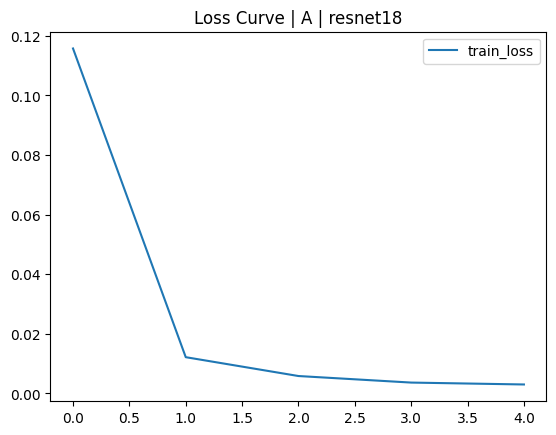

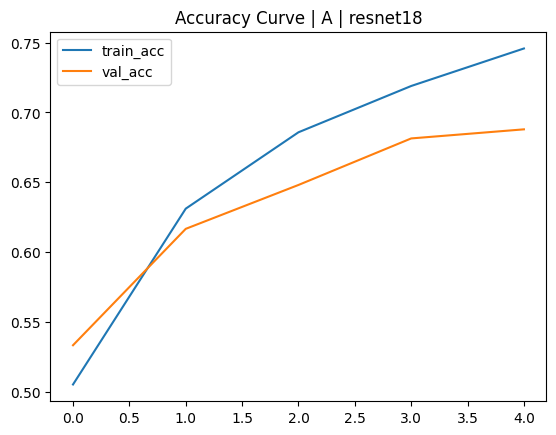

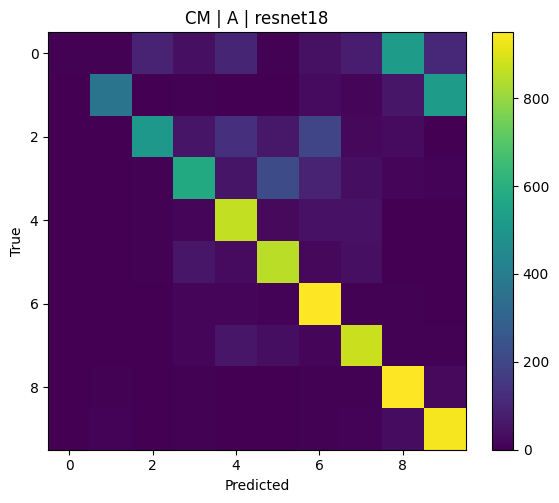

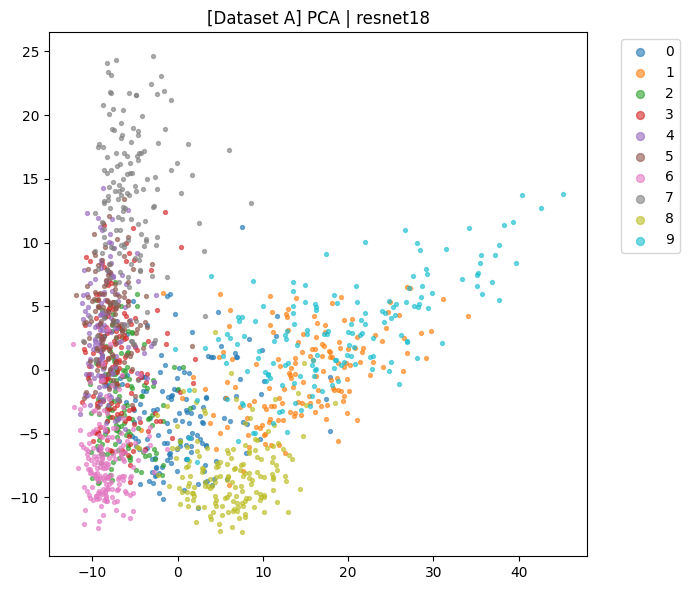

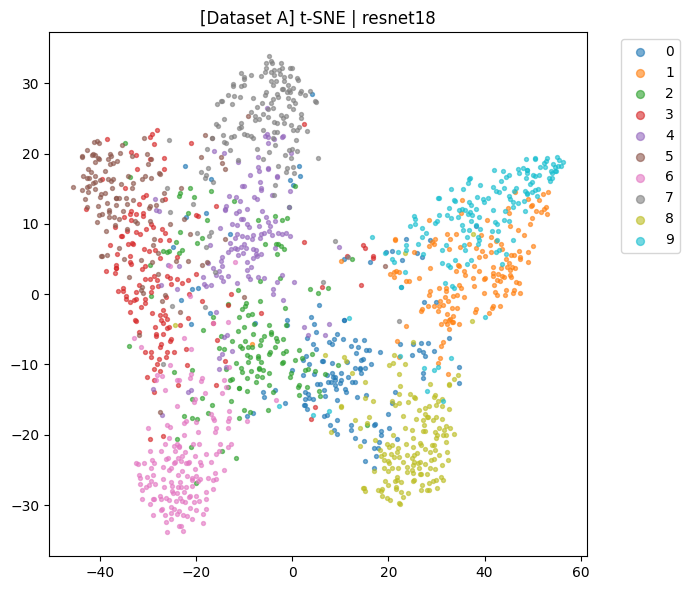

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


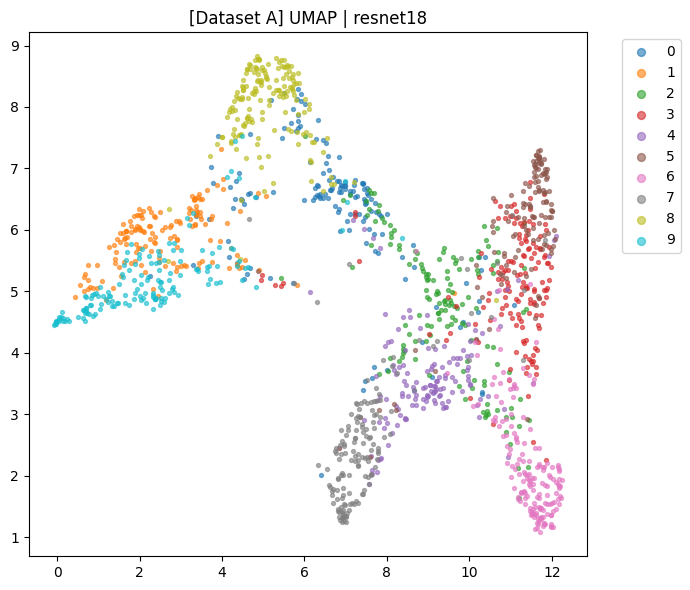

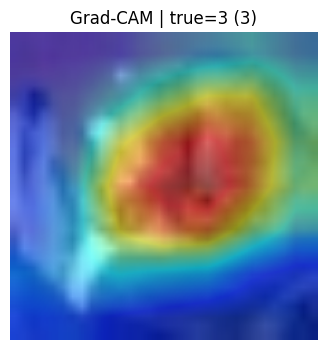

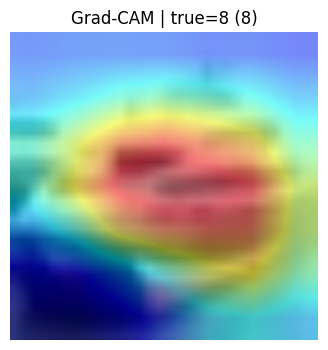

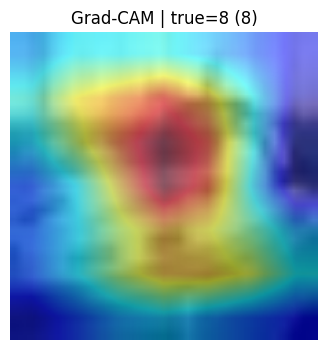

Saved: best_A_resnet18_focal.pth

[Dataset A] Model=efficientnet_b0 | Loss=focal | Opt=adamw
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 180MB/s]


Epoch 01 | train loss 0.2327 acc 0.4705 | val acc 0.5403 bal_acc 0.5403 f1_macro 0.4195


Epoch 02 | train loss 0.0182 acc 0.5994 | val acc 0.6132 bal_acc 0.6132 f1_macro 0.5335


Epoch 03 | train loss 0.0109 acc 0.6538 | val acc 0.6417 bal_acc 0.6417 f1_macro 0.5737


Epoch 04 | train loss 0.0077 acc 0.6814 | val acc 0.6696 bal_acc 0.6696 f1_macro 0.6125


Epoch 05 | train loss 0.0064 acc 0.6940 | val acc 0.6744 bal_acc 0.6744 f1_macro 0.6183


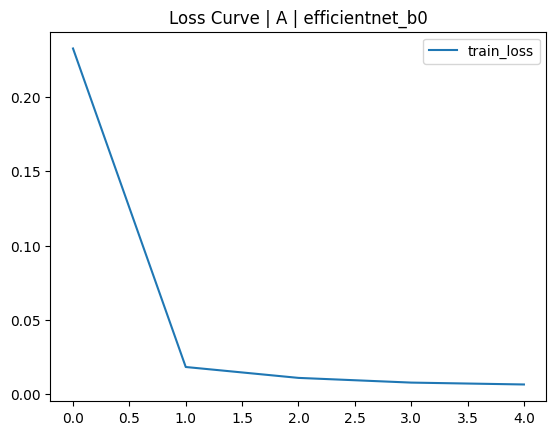

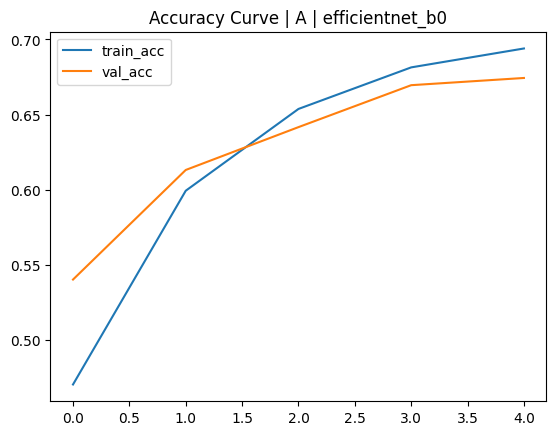

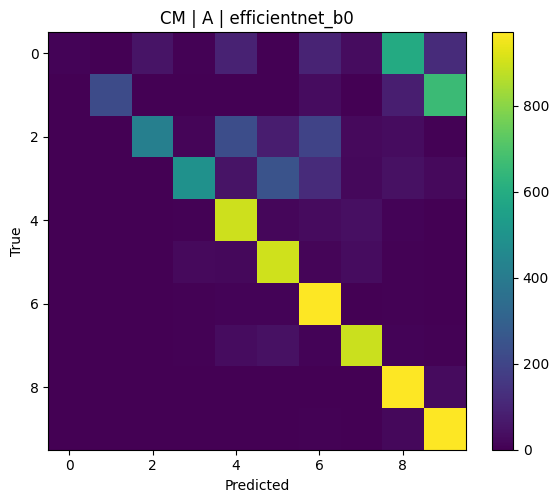

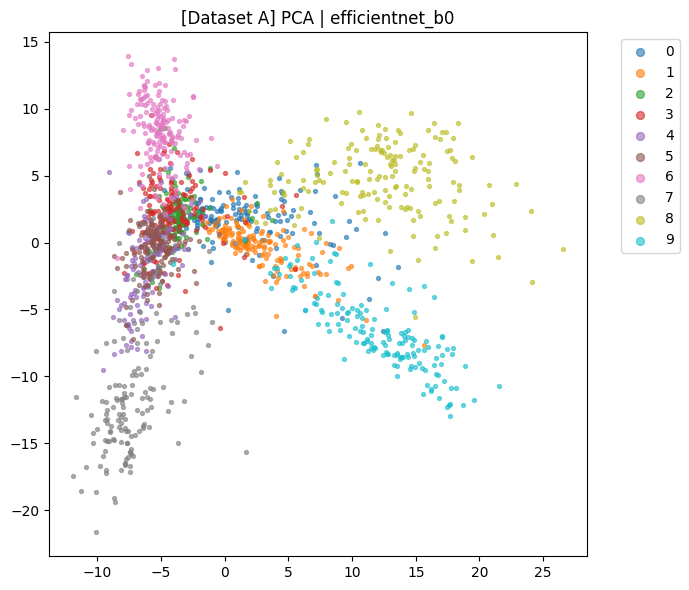

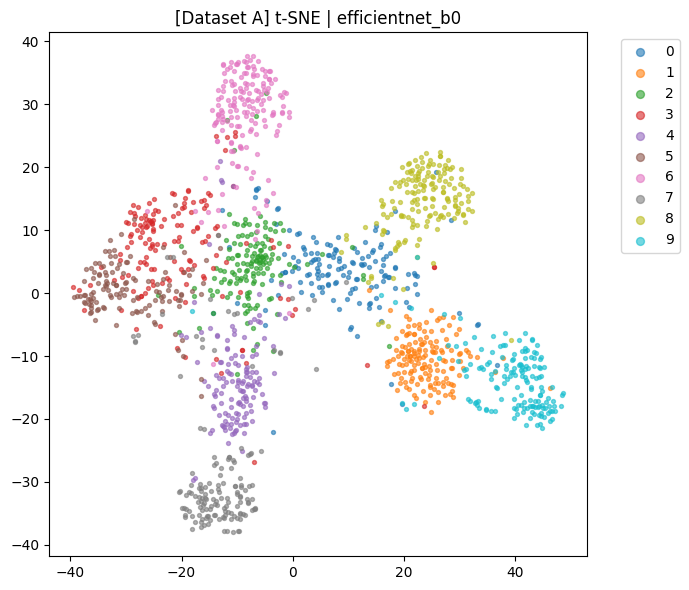

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


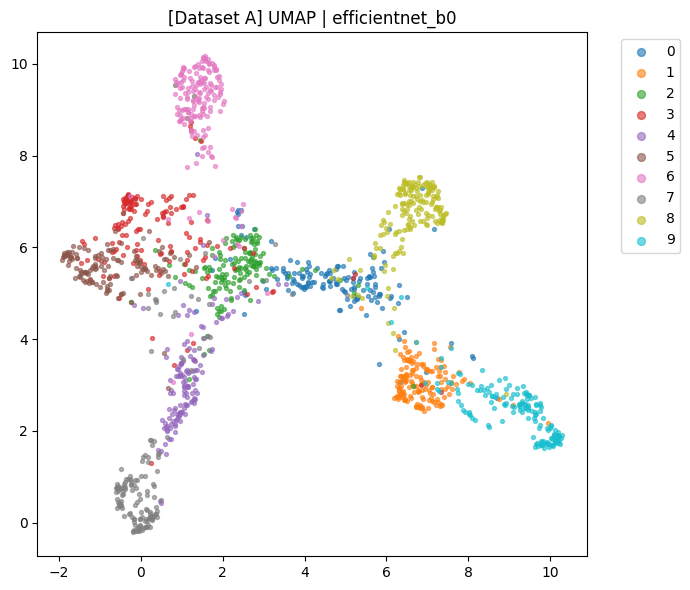

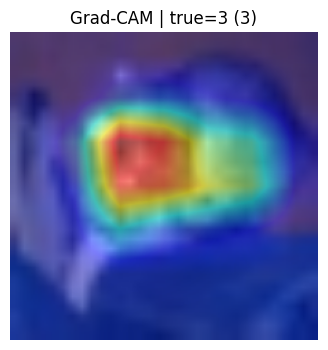

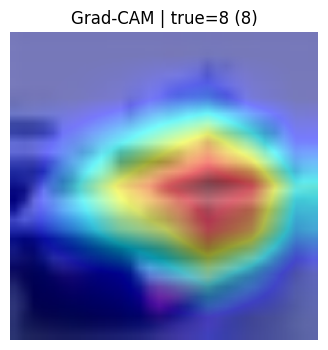

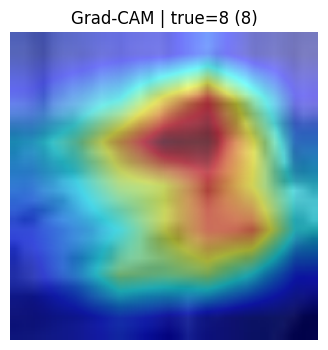

Saved: best_A_efficientnet_b0_focal.pth


In [21]:

# 16) Train & compare at least TWO models on Dataset A (imbalance focus)

def run_experiment_on_dataset(train_loader, test_loader, num_classes, samples_per_cls, class_names, tag="A"):
    results = {}

    # class weights for loss
    class_w = make_class_weights(
        train_targets=targetsA if tag=="A" else targetsB,
        num_classes=num_classes
    ) if cfg.use_class_weights_in_loss else None
    if class_w is not None:
        class_w = class_w.to(device)

    criterion = make_criterion(
        cfg.loss_name,
        class_weights=class_w if cfg.loss_name in ["weighted_ce", "focal"] else None,
        samples_per_cls=samples_per_cls
    ).to(device)

    for model_name in cfg.models_to_compare:
        print("\n" + "="*70)
        print(f"[Dataset {tag}] Model={model_name} | Loss={cfg.loss_name} | Opt={cfg.optimizer_name}")
        model = make_model(model_name, num_classes, pretrained=cfg.pretrained).to(device)

        optimizer = make_optimizer(cfg.optimizer_name, model)
        scheduler = make_scheduler(optimizer)

        history = {"train_loss":[], "train_acc":[], "val_acc":[], "val_f1_macro":[]}
        best = {"acc": -1, "state": None}

        for epoch in range(1, cfg.epochs+1):
            tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion)
            metrics = evaluate(model, test_loader, num_classes)
            scheduler.step()

            history["train_loss"].append(tr_loss)
            history["train_acc"].append(tr_acc)
            history["val_acc"].append(metrics["acc"])
            history["val_f1_macro"].append(metrics["f1_macro"])

            print(f"Epoch {epoch:02d} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | "
                  f"val acc {metrics['acc']:.4f} bal_acc {metrics['balanced_acc']:.4f} "
                  f"f1_macro {metrics['f1_macro']:.4f}")

            if metrics["acc"] > best["acc"]:
                best["acc"] = metrics["acc"]
                best["state"] = copy.deepcopy(model.state_dict())
                best["metrics"] = metrics

        model.load_state_dict(best["state"])

        # Params / FLOPs / inference time
        dummy = torch.randn(1, 3, cfg.image_size, cfg.image_size).to(device)
        macs, params = profile(model, inputs=(dummy,), verbose=False)
        infer_ms = inference_time_ms(model, test_loader, iters=30)

        final_metrics = evaluate(model, test_loader, num_classes)

        results[model_name] = {
            "history": history,
            "metrics": final_metrics,
            "params": int(params),
            "macs": int(macs),
            "infer_ms": infer_ms,
            "model": model
        }

        # Curves
        plt.figure()
        plt.plot(history["train_loss"], label="train_loss")
        plt.title(f"Loss Curve | {tag} | {model_name}")
        plt.legend(); plt.show()

        plt.figure()
        plt.plot(history["train_acc"], label="train_acc")
        plt.plot(history["val_acc"], label="val_acc")
        plt.title(f"Accuracy Curve | {tag} | {model_name}")
        plt.legend(); plt.show()

        # Confusion matrix
        plot_confusion_matrix(final_metrics["cm"], title=f"CM | {tag} | {model_name}")

        # Feature visualization (PCA/tSNE/UMAP) using test set
        visualize_embeddings(model_name, model, test_loader, num_classes,
                             title_prefix=f"[Dataset {tag}]", max_samples=cfg.viz_samples)

        # Grad-CAM demo
        gradcam_demo(model_name, model, test_loader, class_names=class_names, num_images=3)

        # Save best model
        torch.save(model.state_dict(), f"best_{tag}_{model_name}_{cfg.loss_name}.pth")
        print(f"Saved: best_{tag}_{model_name}_{cfg.loss_name}.pth")

    return results

results_A = run_experiment_on_dataset(
    trainA_loader, testA_loader, nA, perA, namesA, tag="A"
)


# PS 7: Transfer Learning Evaluation

This section evaluates model generalization by transferring knowledge from one dataset to another.

Best model on Dataset A: resnet18 acc= 0.6879

TRANSFER: Train on A, Transfer to B (fine-tune)
Loaded 120/122 params from best_A_resnet18_focal.pth


[Transfer] Epoch 01 | train acc 0.8407 | val acc 0.8519 bal_acc 0.8578 f1_macro 0.8511


[Transfer] Epoch 02 | train acc 0.9485 | val acc 0.8866 bal_acc 0.8899 f1_macro 0.8854


[Transfer] Epoch 03 | train acc 0.9751 | val acc 0.9282 bal_acc 0.9289 f1_macro 0.9274


[Transfer] Epoch 04 | train acc 0.9925 | val acc 0.9340 bal_acc 0.9339 f1_macro 0.9333


[Transfer] Epoch 05 | train acc 0.9948 | val acc 0.9329 bal_acc 0.9324 f1_macro 0.9313


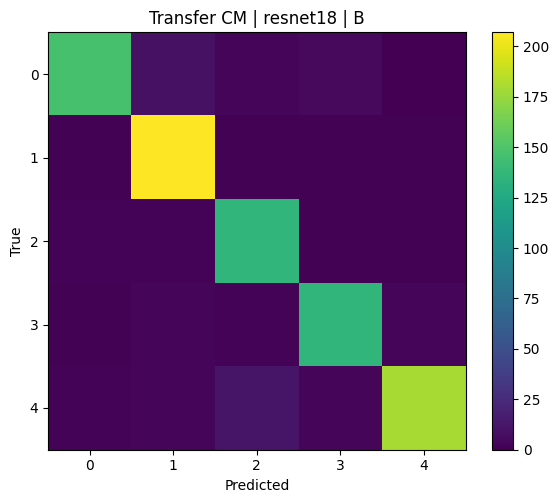

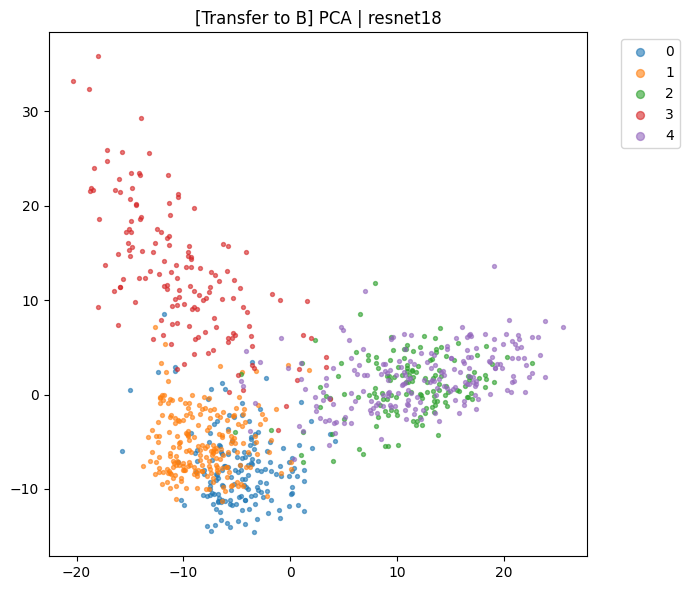

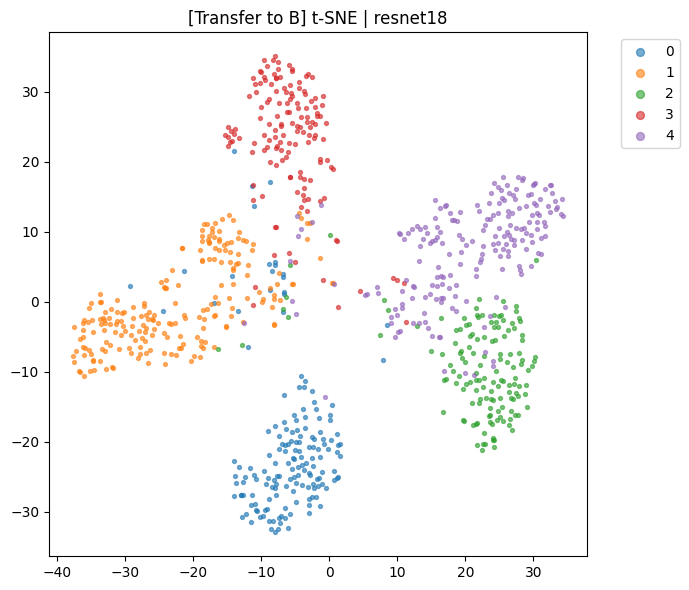

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


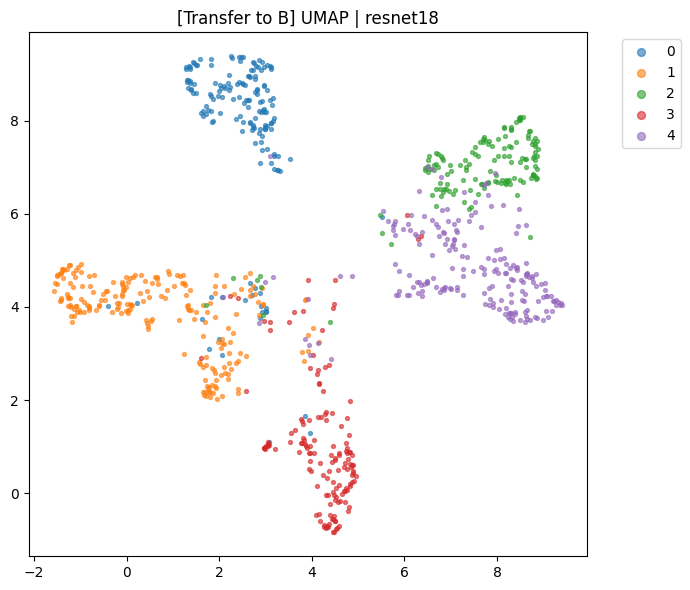

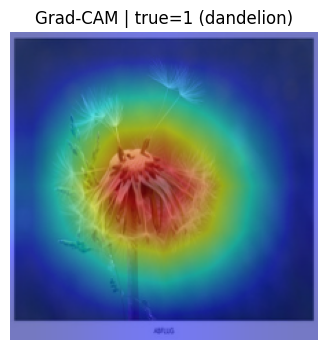

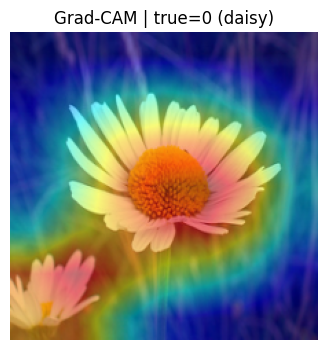

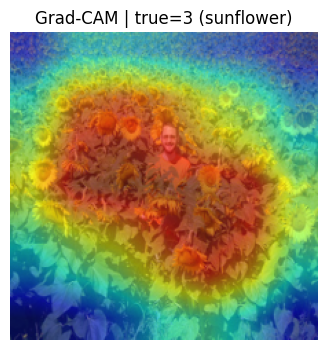

Saved: transfer_to_B_resnet18_focal.pth


In [22]:

# 17) Transfer Learning Test (train on A → test on B)
#     - Option 1: direct transfer (no finetune) if same #classes (rare)
#     - Option 2 (recommended): load backbone weights from best A model,
#       replace head for B and finetune on B

def transfer_A_to_B(best_model_name):
    print("\n" + "="*70)
    print("TRANSFER: Train on A, Transfer to B (fine-tune)")

    # 1) Build same architecture for B
    modelB = make_model(best_model_name, nB, pretrained=cfg.pretrained).to(device)

    # 2) Load weights from A checkpoint (except classifier head)
    ckpt_path = f"best_A_{best_model_name}_{cfg.loss_name}.pth"
    stateA = torch.load(ckpt_path, map_location="cpu")
    stateB = modelB.state_dict()

    # load matching keys only
    matched = {k: v for k, v in stateA.items() if k in stateB and v.shape == stateB[k].shape}
    stateB.update(matched)
    modelB.load_state_dict(stateB)
    print(f"Loaded {len(matched)}/{len(stateB)} params from {ckpt_path}")

    # 3) Train on B
    # class weights
    class_wB = make_class_weights(targetsB, nB).to(device) if cfg.use_class_weights_in_loss else None
    criterionB = make_criterion(cfg.loss_name,
                               class_weights=class_wB if cfg.loss_name in ["weighted_ce","focal"] else None,
                               samples_per_cls=perB).to(device)
    optimizerB = make_optimizer(cfg.optimizer_name, modelB)
    schedulerB = make_scheduler(optimizerB)

    for epoch in range(1, cfg.epochs+1):
        tr_loss, tr_acc = train_one_epoch(modelB, trainB_loader, optimizerB, criterionB)
        metrics = evaluate(modelB, testB_loader, nB)
        schedulerB.step()
        print(f"[Transfer] Epoch {epoch:02d} | train acc {tr_acc:.4f} | "
              f"val acc {metrics['acc']:.4f} bal_acc {metrics['balanced_acc']:.4f} f1_macro {metrics['f1_macro']:.4f}")

    # Evaluate + visualize
    finalB = evaluate(modelB, testB_loader, nB)
    plot_confusion_matrix(finalB["cm"], title=f"Transfer CM | {best_model_name} | B")
    visualize_embeddings(best_model_name, modelB, testB_loader, nB,
                         title_prefix="[Transfer to B]", max_samples=cfg.viz_samples)
    gradcam_demo(best_model_name, modelB, testB_loader, class_names=namesB, num_images=3)

    torch.save(modelB.state_dict(), f"transfer_to_B_{best_model_name}_{cfg.loss_name}.pth")
    print(f"Saved: transfer_to_B_{best_model_name}_{cfg.loss_name}.pth")

# Pick the best model from A by val acc (from results_A)
best_name = max(results_A.keys(), key=lambda k: results_A[k]["metrics"]["acc"])
print("Best model on Dataset A:", best_name, "acc=", results_A[best_name]["metrics"]["acc"])
transfer_A_to_B(best_name)

# PS 4: Performance Metrics and Analysis

This section summarizes evaluation metrics including accuracy, F1-score, ROC-AUC, and confusion matrix.

In [23]:

# 18) Summary table (prints metrics you can paste in report)

def print_summary(results, tag="A"):
    print("\n" + "="*80)
    print(f"SUMMARY (Dataset {tag})")
    for name, obj in results.items():
        m = obj["metrics"]
        print(f"- {name}: acc={m['acc']:.4f}, top5={m['top5']:.4f}, bal_acc={m['balanced_acc']:.4f}, "
              f"f1_macro={m['f1_macro']:.4f}, roc_auc={m['roc_auc_macro']:.4f}, pr_auc={m['pr_auc_macro']:.4f}, "
              f"gmean={m['gmean']:.4f}, params={obj['params']}, MACs={obj['macs']}, infer_ms={obj['infer_ms']:.2f}")

print_summary(results_A, tag="A")


SUMMARY (Dataset A)
- resnet18: acc=0.6879, top5=0.9624, bal_acc=0.6879, f1_macro=0.6408, roc_auc=0.9754, pr_auc=0.8622, gmean=0.4429, params=11181642, MACs=1823526912, infer_ms=101.23
- efficientnet_b0: acc=0.6744, top5=0.9517, bal_acc=0.6744, f1_macro=0.6183, roc_auc=0.9642, pr_auc=0.8417, gmean=0.4445, params=4020358, MACs=413877824, infer_ms=142.76
